# Cargar los datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install tslearn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.optimizers import Adam

In [ ]:
data = arff.loadarff("/content/drive/MyDrive/MasterKISA/ITSDA/Entrega2/MoteStrain.arff")
df = pd.DataFrame(data[0])

print(df)

          att1      att2      att3      att4      att5      att6      att7  \
0     0.398150  0.503921  0.525904  0.607302  0.572887  0.804101  0.721741   
1    -1.094367 -1.251307 -1.417703 -1.501493 -1.354483 -1.193750 -1.036556   
2     0.081700  0.057580  0.019309 -0.017998 -0.045013 -0.058199 -0.122842   
3    -1.425477 -1.451659 -1.486758 -1.535277 -1.558609 -1.582891 -1.620021   
4    -0.500857 -0.529616 -0.569820 -0.624989 -0.678105 -0.712733 -0.744573   
...        ...       ...       ...       ...       ...       ...       ...   
1267 -0.893472 -0.832249 -0.876202 -1.006601 -0.724068 -0.559684 -0.363747   
1268 -1.035570 -1.066416 -1.079312 -0.887277 -1.075031 -1.114812 -1.156933   
1269 -0.128368  0.020477  0.043310  0.168652  0.185692  0.054735  0.036175   
1270 -0.137098 -0.069321 -0.011841  0.034630  0.089795  0.185531  0.242654   
1271 -1.362242 -1.425053 -1.388289 -1.207359 -1.176210 -1.170550 -0.991909   

          att8      att9     att10  ...     att76     att77    

In [ ]:
clases = df.iloc[:, -1]
clases.value_counts()

,count
target,
b'1',685
b'2',587


Hay 1272 instancias, de las cuales 685 son de la clase 1 () y 587 son de la clase 2 ().

Para hacer el split de train test, dividir en la proporcion 80, 20 los datos de manera stratified.

In [ ]:
X = df.drop(columns=['target']).values
y = pd.Categorical(df['target']).codes

X = X.reshape(X.shape[0], X.shape[1], 1)
# División estratificada en 80% para entrenamiento y 20% para prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Verificar las proporciones
print("Distribución en y_train:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nDistribución en y_test:")
print(pd.Series(y_test).value_counts(normalize=True))

Distribución en y_train:
0    0.53884
1    0.46116
Name: proportion, dtype: float64

Distribución en y_test:
0    0.537255
1    0.462745
Name: proportion, dtype: float64


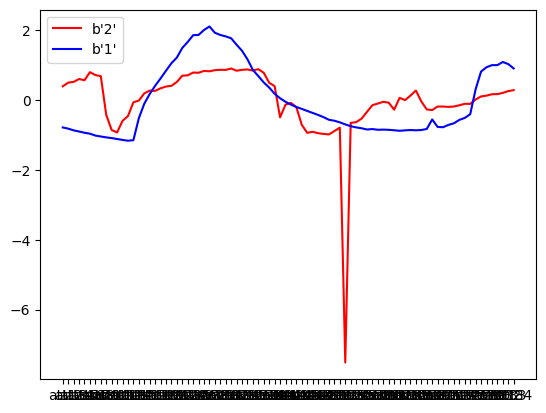

In [ ]:
# Extraer la primera fila y los nombres de las columnas
row0 = df.iloc[0]
row1 = df.iloc[400]
class_label0 = row0.iloc[-1]  # Última columna (la clase)
values0 = row0.iloc[:-1]  # Todas las columnas excepto la última
class_label1 = row1.iloc[-1]  # Última columna (la clase)
values1 = row1.iloc[:-1]  # Todas las columnas excepto la última

plt.plot(values0, color='red', label=class_label0)
plt.plot(values1, color='blue', label=class_label1)
plt.legend()
plt.show()

# 1-NN

In [ ]:
knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")
knn_dtw.fit(X_train, y_train)

# Realizar predicciones
y_pred = knn_dtw.predict(X_test)

# Evaluar el modelo
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9568627450980393

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       137
           1       0.97      0.94      0.95       118

    accuracy                           0.96       255
   macro avg       0.96      0.96      0.96       255
weighted avg       0.96      0.96      0.96       255



# Shapelets

In [30]:
n_shapelets_per_size = grabocka_params_to_shapelet_size_dict(
    n_ts=X_train.shape[0], ts_sz=X_train.shape[1], n_classes=len(np.unique(y_train)), l=0.1, r=1
)

shapelet_model = ShapeletModel(n_shapelets_per_size=n_shapelets_per_size,
                               optimizer=Adam(learning_rate=0.05),
                               weight_regularizer=0.01,
                               max_iter=200)

shapelet_model.fit(X_train, y_train)

y_pred = shapelet_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Accuracy: 0.8470588235294118

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       137
           1       0.83      0.84      0.84       118

    accuracy                           0.85       255
   macro avg       0.85      0.85      0.85       255
weighted avg       0.85      0.85      0.85       255

